In [85]:
%matplotlib inline
import nimfa
from collections import defaultdict, Counter
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import preprocessing
import scipy.cluster.hierarchy as sch

# Non-negative matrix factorization with RNASeq data

## Introduction

Non-negative matrix factorization is an ensemble of methods that approximate the data ( in a matrix form ) as a 
product of two simple, interpretable matrices. It gained prominence after Lee & Seung developed and used an algorithm that automatically identified local features like eyes and noses in facial image datasets. It differs from other factorization methods such as SVD, PCA and ICA in one crucial aspect that also gives this method its name. The input matrix it operates on and the two simple factor matrices it yields are all non-negative matrices: None of their elements are negative – they are either zero or positive numbers.

In facial image datasets where NMF was originally applied to, images are stored as rectangular array of numbers each carrying the grey intensity of individual pixels. A rectangular array corresponding to each image is then unwrapped to form a long, one-dimensional vector. The vectors so formed from many such images are then combined column-wise to form the input matrix, which we can call X. As the intensity of the pixels are non-negative numbers, non-negative matrix factorization could be applied to this input matrix.  The output of the factorization yields two non-negative matrices, let's say, W and H. When multiplied together these two matrices yield an approximation to the original matrix, X. The loss of information due to approximation is more than compensated by the fewer number of columns in W (which is equal number of rows in H); This fewer basis vectors, as the columns of W are called, combined with the non-negative nature of these matrices allow for easier comprehension and interpretation of the hidden features of the originally incomprehensible, complex data.

![Hi](XeqWH.png)

In the figure above, a toy matrix, X, is decomposed into a left (W) and right (H) factors. The number of basis in the left factor matrix W is less than the number of columns in the data matrix X. The multitude of columns of the X matrix can be regenerated as a linear combination of these fewer bases. For example, the middle column in the data matrix is a sequence of numbers that increase in value as shown by the progreesively warmer colors from top to bottom. And the NMF algorithm has, as a result, picked as a basis a vector that increases in value from top to bottom as shown in the first column of the W matrix. The linear combinations to regenerate the middle column of the data matrix is provided by the coefficients in the middle column of the right factor matrix or the coefficient matrix, H. As expected the coefficient for the first basis is disproportionately higher than the coefficients for the other two bases.

Many sophisticated algorithms for non-negative factorization exist that concern themselves with various aspects like speed, accuracy, sparsity of the basis vectors or the coefficient vectors and so on. Here, we will use a method called sparse non-negative matrix factorization due to Park et. al, 2007, that was implemented in Nimfa python library.


In [82]:
## Code to generate the images for the illustrative figure in the introduction

# X = np.array([[1,2,3,4,5,2,3],[1,4,3,5,5,4,3],[1,2,3,6,5,2,3],[1,4,3,7,5,4,3],[1,2,3,8,5,2,3],
#               [1,4,3,9,5,4,3],[1,2,3,10,5,2,3],[1,4,3,11,5,4,3],[1,2,3,12,5,2,3],[1,4,3,13,5,4,3],
#              [1,2,3,14,5,2,3],[1,4,3,15,5,4,3],[1,2,3,16,5,2,3],[1,4,3,17,5,4,3],[1,2,3,18,5,2,3],
#              [1,4,3,19,5,4,3],[1,2,3,20,5,2,3],[1,4,3,21,5,4,3],[1,2,3,22,5,2,3],[1,4,3,23,5,4,3]])
# ## Model description
# snmf = nimfa.Snmf(X, seed="random_vcol", rank=3, max_iter=100000, version='l',
#                   eta=10.0, beta=1e-4, i_conv=500, w_min_change=0)
# ## Model fitting
# snmf_fit = snmf()

# ## Accessing the left fator W from the fitted model
# W = snmf_fit.basis()
# print(W)

# ## Accessing the right factor from the fitted model
# H = snmf_fit.coef()
# print(X.shape)
# print(W.shape)
# print(H.shape)

# cb = plt.matshow(H[:,:])
# # plt.colorbar()
# # cb.axes.set_xlabel("basis/gene_group")
# # cb.axes.set_ylabel("gene index")
# # cb._short_axis().set_visible(True)
# plt.savefig("H.png",dpi=80, format="png")
# plt.show()



## Downloading and preparing the data matrix from RNASeq data

In [83]:
import pandas as pd

In [86]:
## Reading the count matrix into a data frame
df_aba = pd.read_csv("data/aba_mat_vst.csv")

In [87]:
## dropping the first column with the name of the genes
df_aba_drop = df_aba.drop(columns=df_aba.columns[0])

In [88]:
## converting into a numpy array
d_aba = df_aba_drop.to_numpy()

In [89]:
## The dimensions of the array
m, n = d_aba.shape

## NIMFA package for NMF analysis

### Few notes about NIMFA

The block of code below shows a typical command from [Nimfa]( https://nimfa.biolab.si/ ) library invoked to perform the non-negative matrix factorization. Here, Sparse Non-negative matrix factorization method, Snmf, is called. It tries to produce matrix decompositions with a desired level of sparsity in either of the two matrix factors produced by the factorization algorithm. Most of the codes below were inspired from the tutorial given in the NIMFA package documentation. NIMFA also has many other algorithms for non-negative matrix factorizations listed in their website. 

This link to online ipython notebook from where I got the code snippets below seems to be no longer working. I will update the link once it starts to work.

https://nbviewer.ipython.org/github/marinkaz/nimfa-ipynb/blob/master/ICGC%20and%20Nimfa.ipynb

In [90]:
## Model description
snmf = nimfa.Snmf(d_aba, seed="random_vcol", rank=20, max_iter=100, version='l',
                  eta=1., beta=1e-4, i_conv=10, w_min_change=0)
## Model fitting
snmf_fit = snmf()

In [91]:
## Accessing the left fator W from the fitted model
W = snmf_fit.basis()

In [92]:
## Accessing the right factor from the fitted model
H = snmf_fit.coef()

#### The number of rows of the left factor, W, matches the number of rows of the data matrix. This equals the number of genes in our case. 

In [97]:
d_aba.shape[0] == W.shape[0]

True

#### The columns of W equals the number of bases or rank, which we specified in our model description above (equals 20 here).

In [94]:
W.shape

(16325, 20)

#### The number of columns of the right factor, H, matches the columns of the data matrix. This equals the number of treatments in our case.

In [95]:
d_aba.shape[1] == H.shape[1]

True

#### The number of rows of H equals the number of basis or rank.

In [96]:
H.shape

(20, 28)

### A close look at W and H matrix

The columns of the W matrix is shown for the first 200 genes (the first 200 rows of the W matrix). As mentioned before, the columns indicate the basis/rank of the decomposition and they are also non-negative. Each of the columns can be used to group the genes such that the genes within a group contribute to the idiosyncratic fashion in which that group might behave across the samples. A higher value in a row (gene) for a given column (gene-group) indicate a higher contribution of the corresponding gene towards the signature activity pattern of that group of genes associated with the column in consideration. We can explore the behaviour of a particular group of genes across the treatments/samples by analyzing the corresponding row in the H matrix. We will postpone such exploration of the H matrix for later when we would try to find a better decomposition in terms of the ability of the decomposition to capture the sparse features present in the expression data. 

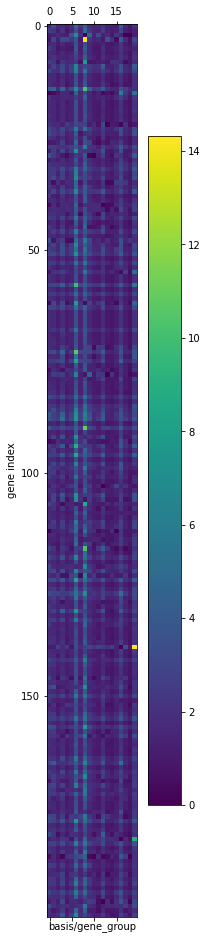

In [98]:
cb = plt.matshow(W[:200,:])
plt.colorbar()
cb.axes.set_xlabel("basis/gene_group")
cb.axes.set_ylabel("gene index")
# cb._short_axis().set_visible(True)
plt.savefig("W_sample.png",dpi=300, format="png")
plt.show()

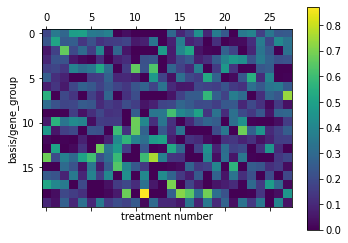

In [99]:
cb = plt.matshow(H[:,:])
plt.colorbar()
cb.axes.set_xlabel("treatment number")
cb.axes.set_ylabel("basis/gene_group")
plt.savefig("H_sample.png",dpi=300, format="png")
plt.show()

### Choosing the optimal rank parameter
We will run decompositions for a range of rank parameters and choose, based on the estimates of sparseness and reliability, the best one among them. We will continue with this chosen parameter for further analyses.


What these parameters are and what do we need from them?

rss --> residual sum-of-squares -- The sum of the squares of the deviation of the approximated values from the the original values of the input matrix they are approximating. The lesser the rss, the better. 

cophenetic correlation --> 
NMF groups genes into classes that might signal gene-clusters that work as a cohesive unit. NMF is also a stochastic algorithm that changes result as the initial condition is changed. It could happen that the classes to which a gene is assigned keep changing as the initial conditions of the numerical algorithm are changed. Cophenetic correlarion measures the robustness of the groups gleaned from multiple runs of the NMF method. A cophenetic correlation close to 1 implies a gene-group assignment that withstands the assault of initial-condition changes. This can boost the confidence in the biological relevance of the group-assignment. A cophenetic correlation close to zero, on the other hand, either signals the presence of poor group assignments of the algorithm, which could be improved by changing the rank parameter, or a lack of structure in the expression data, which is not going to be resolved by changing the rank parameter.

dispersion -->     
Dispersion coeffient as espoused in Kim & Park 2007. It is estimated from the entries of a consensus matrix, which is the average of the membership matrices evaluated across many initial conditions. For each run (given an initial condition) if the sample i and sample j belong to the same group then the ij-th entry of the membership matrix is set to 1 otherwise it is set to zero. The dispersion coefficient calculated from the consensus matrix is close to zero if the entries of the consensus matrix are scatered between 0 and 1, which would be the case if the group assignment staggered across different initial conditions. It is close to 1 if the entries of consensus matrix are either 0 or 1, which would be the ideal case where the group assignment is impervious to changes in intial conditions.

sparseness -->
Sparseness is estimated as the sum of the column-wise L1 norms of the W matrix and the sum of the row-wise L1 norms of the H matrix combined into one grand sum. L1 norm is similar to L2 norm used in calculating the euclidean distances, except that the absolute values, instead of the squared values, of the individual entries are used in calculating the norm. This has the benefit of enforcing sparsity of the entries at the cost of losing some accuracy when incorporated into the factorization algorithm.



In [100]:
## range of rank parameters -- [3, 8, 13, 18, 23, 28]
rank_cands = range(3, 30, 5)
## Model specification
snmf = nimfa.Snmf(d_aba, seed='random_vcol', max_iter=100, version='l', beta=0.01)
## Running the function to estimate the qualities for a range of rank parameters  
summary = snmf.estimate_rank(rank_range=rank_cands, n_run=10, what='all')

In [19]:
# help(plt.savefig)

Text(0.5, 0, 'Rank')

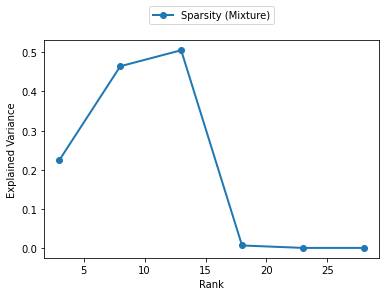

In [107]:
## Plotting the measures of quality for all the ranks we used
rss = [summary[rank]['rss'] for rank in rank_cands]
coph = [summary[rank]['cophenetic'] for rank in rank_cands]
disp = [summary[rank]['dispersion'] for rank in rank_cands]
spar = [summary[rank]['sparseness'] for rank in rank_cands]
spar_w, spar_h = zip(*spar)
evar = [summary[rank]['evar'] for rank in rank_cands]

# plt.plot(rank_cands, rss, 'o-', label='RSS', linewidth=2, color="k")
# plt.plot(rank_cands, coph, 'o-', label='Cophenetic correlation', linewidth=2)
# plt.plot(rank_cands, disp,'o-', label='Dispersion', linewidth=2, color="k")
# plt.plot(rank_cands, spar_w, 'o-', label='Sparsity (Basis)', linewidth=2)
#plt.plot(rank_cands, spar_h, 'o-', label='Sparsity (Mixture)', linewidth=2)
plt.plot(rank_cands, evar, 'o-', label='Explained variance', linewidth=2, color="k")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=3, numpoints=1);
plt.ylabel("Explained Variance")
plt.xlabel("Rank")
# plt.savefig("evar_vs_rank.png",dpi=300, format="png")

### NMF Decomposition with the best of the parameters
From the quality estimates we have zeroed in on rank 13 as the one that lead to sparse bases with maximum variance explained and minimum amount of errors accrued in approximating the original data matrix. We will run NMF decomposition using this parameter and will analyze the factors we obtained in detail.

In [591]:
## Model specification 
rank = 13
snmf = nimfa.Snmf(d_aba, rank=rank, seed='random_vcol', version='l', max_iter=100, beta=0.01)


In [592]:
## Fitting the model
snmf_fit = snmf()

In [507]:
## Extracting the W (with basis/gene_group as columns) matrix
W = snmf_fit.fit.basis()


In [508]:
## Extracting the H (with rows corresponding to the coeeficients of each basis/gene_group to obtain the treatment columns as a weighted sum of bases. 
H = snmf_fit.coef()

There is one to one relationship between the columns of the H matrix and the treatment columns of the original matrix. Infact, it would be instructive to view each treatment column as a weighted sum of bases in W. The weights for this sum are provided by the corresponding column of the H matrix. As we have already mentioned, each of the basis vector/column from the W matrix can be used to define a locally prominent gene-groups (the rows with the topmost values in a particular basis in W matrix). If we want to know the treatments to which a given basis/gene-group contributed heavily, we can infer it from glancing at the rows of the H matrix. For example, the basis/gene-group corresponding to the fifth column of the H matrix shown in figure.X rises in its prominence whenever the corresponding column is from one the of ABA treatments. ~This can be easily seen in another version of the same matrix where the columns are re-shuffled to group ABA and no-ABA columns~. One of the enriched gene ontology terms in this group of genes is ABA signalling validating our insight gained from glancing at the row of H.


In another example, the gene-group corresponding to the 10th row of the H matrix is enriched for gene-ontology term "vegetative-to-reproductive state" transition. Accordingly the numerical value of the row increases over time and is strongly emphasized at the later time points.




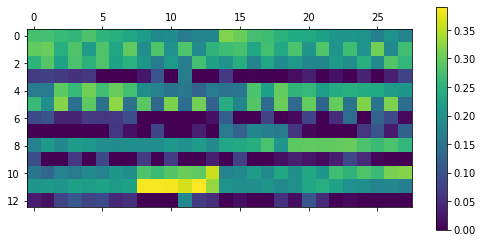

In [509]:
plt.matshow(H[:,:])
plt.colorbar()
plt.show()

For better interpretation of the H matrix, we can permute the columns

In [541]:
aba_ind = list(range(0,28,2)) 
no_aba_ind = list(range(1,28,2))
a_ind_f = aba_ind[:int(len(aba_ind)/2)]
a_ind_s = aba_ind[int(len(aba_ind)/2):]
em = []
for i,j in zip(a_ind_f,a_ind_s):
    em.extend([i,j])
aba_ind = em

na_ind_f = no_aba_ind[:int(len(no_aba_ind)/2)]
na_ind_s = no_aba_ind[int(len(no_aba_ind)/2):]
em = []
for i,j in zip(na_ind_f,na_ind_s):
    em.extend([i,j])
no_aba_ind = em

print(aba_ind)
print(no_aba_ind)
new_ind = aba_ind
new_ind.extend(no_aba_ind)
print(new_ind)

[0, 14, 2, 16, 4, 18, 6, 20, 8, 22, 10, 24, 12, 26]
[1, 15, 3, 17, 5, 19, 7, 21, 9, 23, 11, 25, 13, 27]
[0, 14, 2, 16, 4, 18, 6, 20, 8, 22, 10, 24, 12, 26, 1, 15, 3, 17, 5, 19, 7, 21, 9, 23, 11, 25, 13, 27]


Early Response 

The cluster to which the sample are assigned

In [542]:
H_new = H[:,new_ind]

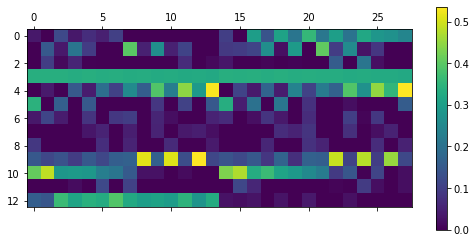

(array([0]), array([10]))
(array([0]), array([10]))
(array([0]), array([12]))
(array([0]), array([3]))
(array([0]), array([12]))
(array([0]), array([3]))
(array([0]), array([12]))
(array([0]), array([0]))
(array([0]), array([9]))
(array([0]), array([9]))
(array([0]), array([9]))
(array([0]), array([9]))
(array([0]), array([9]))
(array([0]), array([9]))
(array([0]), array([10]))
(array([0]), array([10]))
(array([0]), array([3]))
(array([0]), array([10]))
(array([0]), array([3]))
(array([0]), array([3]))
(array([0]), array([1]))
(array([0]), array([1]))
(array([0]), array([4]))
(array([0]), array([4]))
(array([0]), array([4]))
(array([0]), array([4]))
(array([0]), array([4]))
(array([0]), array([4]))


In [590]:
W_ne = snmf_fit.fit.basis()
H_ne = snmf_fit.coef()
plt.matshow(H_ne[:,new_ind])
plt.colorbar()
plt.show()
# for column in H_ne.T:
#     print(np.where(column==np.max(column)))

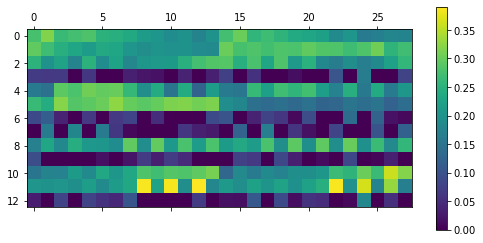

In [543]:
plt.matshow(H_new.squeeze())
plt.colorbar()
plt.show()

In [544]:
genes = df_aba['Unnamed: 0']

gene2id = {gene: idx for idx, gene in enumerate(genes)}
id2gene = dict(zip(gene2id.values(), gene2id.keys()))


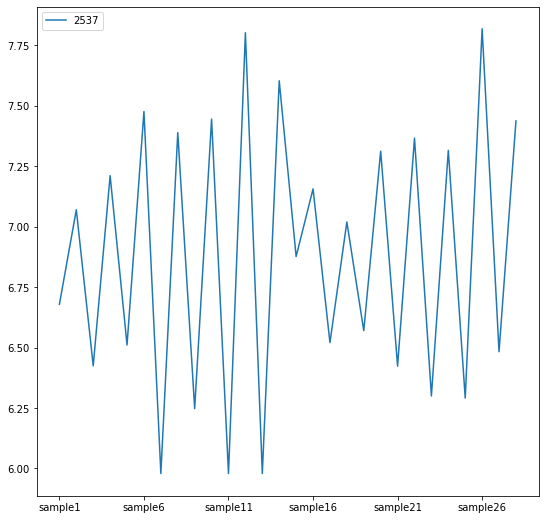

In [545]:
## Using the labels subset the original dataframe with raw expression data and plot them to check if indeed they express differently with ABA
#labels
new_labels = ['AT1G51270']
df_to_plot = df_aba[df_aba["Unnamed: 0"].isin(new_labels)]
df_to_plot_drop = df_to_plot.drop(columns=df_aba.columns[0])
ax = df_to_plot_drop.T.plot(figsize=(9,9))


In [546]:

def common_nmfBasis_pcs(basis_num, pc_num, top_k=500):
    file = open("pc{}_gene_list.txt".format(pc_num),"r")
    list_target = file.readlines()
    file.close()
    list_target_strp = []
    for ele in list_target:
        list_target_strp.append(ele.strip())

    c = basis_num
    k = top_k
    topk = np.argsort(np.asarray(W[:, c]).flatten())[-k:]
    labels = [id2gene[idx] for idx in topk]
    common_nmf_pc = set(list_target_strp) & set(labels)
    fN = open("common_pc_{}_basisNum_{}.txt".format(pc_num, basis_num),"w")
    for gen in common_nmf_pc:
        fN.write(gen)
        fN.write("\n")
    fN.close()
    return 

In [443]:
common_nmfBasis_pcs(3,6)

In [547]:
diction_to_save = {"rank_cands":rank_cands, "rss":rss, "coph":coph, 
                   "disp":disp, "spar_w":spar_w, "spar_h":spar_h,
                   "evar":evar, "best_rank":13, "best_W":W, "best_H":H}

In [ ]:
# import numpy as np

# # Save
# dictionary = {'hello':'world'}
# np.save('my_file.npy', dictionary) 

# # Load
# read_dictionary = np.load('my_file.npy',allow_pickle='TRUE').item()
# print(read_dictionary['hello']) # displays "world"

In [548]:
import numpy as np

# Save
np.save('NMF_ABA_timeEvolve_summary_and_WH.npy', diction_to_save) 

In [551]:
def write_top_genes_to_file(basis_num, top_k):
    c = basis_num
    k = top_k

    topk = np.argsort(np.asarray(W[:, c]).flatten())[-k:]
    val = W[topk, c]
    # val.squeeze().shape
    # val[:,0]

    #print([float(x) for x in val])

    #plt.barh(np.arange(k) + .5, [float(x) for x in val], align="center")
    # labels = [id2gene[idx] for idx in topk]
    # plt.yticks(np.arange(k) + .5, labels)
    # plt.xlabel("Weight")
    # plt.ylabel("Gene");
    labels = [id2gene[idx] for idx in topk]
    # plt.yticks(np.arange(k) + .5, labels)
    # plt.xlabel("Weight")
    # plt.ylabel("Gene");
    fN = "gene_basis_{}_top{}.txt".format(c,k)
    fileObj = open(fN, "w")
    for ele in labels:
        fileObj.write(ele)
        fileObj.write("\n")
    fileObj.close()
    print("Written to file {}".format(fN))

In [552]:
l_bnum = list(range(0,13))
top_k = 400

for basis_num in l_bnum:
    write_top_genes_to_file(basis_num, top_k)


Written to file gene_basis_0_top400.txt
Written to file gene_basis_1_top400.txt
Written to file gene_basis_2_top400.txt
Written to file gene_basis_3_top400.txt
Written to file gene_basis_4_top400.txt
Written to file gene_basis_5_top400.txt
Written to file gene_basis_6_top400.txt
Written to file gene_basis_7_top400.txt
Written to file gene_basis_8_top400.txt
Written to file gene_basis_9_top400.txt
Written to file gene_basis_10_top400.txt
Written to file gene_basis_11_top400.txt
Written to file gene_basis_12_top400.txt


In [232]:
rank = 13
nmf = nimfa.Snmf(d_aba, rank=rank, seed='random_vcol', max_iter = 200, n_run=50, track_factor=True, consensus=True, version='l')
nmf_fit = nmf()



### The later time-point samples can be distinguished reliably from gene-group activity patterns 

The H matrix factor we got from the NMF factorization can be used to group or cluster the samples. But, The NMF is sensitive to changes in initial conditions and thus can lead to different factorization approximations on each run. Thus, a consistent group identity throughout these run would imply an inherent activity of genes most likely to influence the behaviour across the samples in the group. We are interested in arriving at such biologically relevant sample-clusters, i.e, sample-clusters defined by predominance of certain gene-groups that exclusively underpin the response/phenotype in those samples. 

The sample clusters that are robust to initial condition changes can be inferred from a summary of group identities as reflected in a consensus matrix shown in Fig.X. Here, the samples that stick together are grouped using hierarchical clustering  
The clustering achieved via multiple runs of the NMF algorith for different intial conditions show that the samples taken at a later time point (at 12,24 and 60 hours) tend to cluster very reliably. 

How does NMF cluster samples? and what does it tell us?




/tmp/ipykernel_45158/1438619510.py:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = sch.linkage(C, method='average')


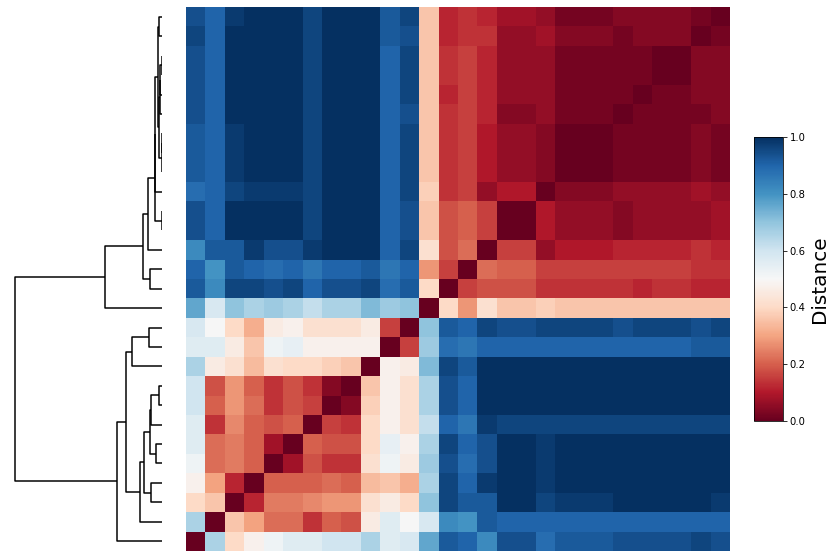

In [233]:
def clean_axis(ax):
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    for sp in ax.spines.values():
        sp.set_visible(False)

fig = plt.figure(figsize=(13.9, 10))
heatmapGS = gridspec.GridSpec(1, 2, wspace=.01, hspace=0., width_ratios=[0.25,1])

C = 1 - nmf_fit.fit.consensus()
Y = sch.linkage(C, method='average')

denAX = fig.add_subplot(heatmapGS[0,0])
denD = sch.dendrogram(Y, orientation='left', link_color_func=lambda k: 'black')
clean_axis(denAX)

heatmapAX = fig.add_subplot(heatmapGS[0,1])
D = C[denD['leaves'], :][:, denD['leaves']]
axi = heatmapAX.imshow(D, interpolation='nearest', aspect='equal', origin='lower', cmap='RdBu') 
clean_axis(heatmapAX)

cb = fig.colorbar(axi, fraction=0.046, pad=0.04, aspect=10) 
cb.set_label('Distance', fontsize=20)

In [27]:
# denD

In [25]:
# from goatools import obo_parser

In [24]:
# !pip install wget

In [28]:
# import wget 
# import os 
# import gzip
# import Bio.UniProt.GOA as GOA
# from goatools.go_enrichment import GOEnrichmentStudy
# from goatools.godag_plot import plot_gos, plot_results, plot_goid2goobj
# from IPython.display import Image

In [29]:
# go_obo_url = "http://purl.obolibrary.org/obo/go/go-basic.obo"
# data_folder = os.getcwd() + "/data"

In [30]:
# from goatools.obo_parser import GODag
# obodag = GODag("data/go-basic.obo")
            

In [31]:
# arab_uri = "http://current.geneontology.org/annotations/tair.gaf.gz"
# arab_fn = arab_uri.split('/')[-1]
# wget.download(arab_uri, os.path.join(data_folder,arab_fn))

In [32]:
# arab_gaf = os.path.join(data_folder, arab_fn)
# with gzip.open(arab_gaf, 'rt') as arab_gaf_fp:
#     arab_funcs = {}  # Initialise the dictionary of functions
    
#     # Iterate on each function using Bio.UniProt.GOA library.
#     for entry in GOA.gafiterator(arab_gaf_fp):
#         #print(entry)
#         tair_id = entry.pop('DB_Object_ID')
#         arab_funcs[tair_id] = entry

In [33]:
# assoc = {}

# for x in arab_funcs:
#     if x not in assoc:
#         assoc[x] = set()
#     assoc[x].add(str(arab_funcs[x]['GO_ID']))

In [34]:

# goeaobj = GOEnrichmentStudy(
#         arab_funcs.keys(), # List of mouse protein-coding genes
#         assoc, # geneid/GO associations
#         obodag, # Ontologies
#         propagate_counts = False,
#         alpha = 0.05, # default significance cut-off
#         methods = ["bonferroni"]) # defult multipletest correction method

In [35]:
# goea_results_all = goeaobj.run_study(labels)

In [36]:
# #r = goea_results_all[0]
# #dir(r)
# goea_results_sig = [r for r in goea_results_all if r.p_bonferroni < 0.05]

In [37]:
# plot_results("nbt3102_{NS}.png", goea_results_sig)

In [38]:
# Image("nbt3102_BP.png")

In [39]:
# help(GOEnrichmentStudy)